<a href="https://colab.research.google.com/github/BrukMak/Multi-Species-Mosquito-Detection-with-Audio-Classification/blob/main/Multi_Species_Mosquito_Detection_with_Audio_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/drive/MyDrive/appsheet/Pramp/WingBeatsDS.zip -d /content/
!unzip /content/drive/MyDrive/WingBeatsDS.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_200633_207_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_200643_208_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_200736_209_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_200753_210_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_200812_211_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_201000_212_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_201024_213_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_201025_214_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_201026_215_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_201026_216_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_201038_217_G_050.wav  
  inflating: /content/WingBeatsDS/Ae. albopictus/F170102_201056_218_G

Connenting to drive

from google.colab import drive
drive.mount('/content/drive')

Unzipping the dataset

Import Necessary Libraries

In [ ]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import soundfile as sf

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, MaxPooling2D, Conv2D, Resizing
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Fetching the dataset

In [ ]:
data_dir = '/content/WingBeatsDS'

In [ ]:
# # To check the number of channel and frame rate

# import wave

# audio_file = "/content/WingBeatsDS/Ae. aegypti/F161212_194708_176_G_050.wav"
# audio_file2 = "/content/WingBeatsDS/Ae. aegypti/2023-06-12 092110.627084 audio.wav"

# with wave.open(audio_file2, "rb") as wav:
#     num_channels = wav.getnchannels()
#     sample_width = wav.getsampwidth()
#     frame_rate = wav.getframerate()
#     num_frames = wav.getnframes()

# print("Number of channels:", num_channels)
# print("Sample width:", sample_width)
# print("Frame rate:", frame_rate)
# print("Number of frames:", num_frames)


Spliting for training and validation data

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')


Found 6588 files belonging to 6 classes.
Using 5271 files for training.
Using 1317 files for validation.


In [ ]:
label_names = np.array(train_ds.class_names)
label_names

array(['Ae. aegypti', 'Ae. albopictus', 'An. arabiensis', 'An. gambiae',
       'C. pipiens', 'C. quinquefasciatus'], dtype='<U19')

In [ ]:
# The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels)
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
def squeeze(audio, label):
  audio = tf.squeeze(audio, axis = -1)
  return audio, label
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


Spliting the validation portion in to two so that half of the data could be used for testing

In [ ]:
# The utils.audio_dataset_from_directory function only returns up to two splits.
# It's a good idea to keep a test set separate from your validation set. Ideally you'd keep it in a separate directory,
# but in this case you can use Dataset.shard to split the validation set into two halves.
# Note that iterating over any shard will load all the data, and only keep its fraction.
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)


In [ ]:
#Cheking the label of all the species in out data set
# label_names[[1,1,3,0]]

array(['Ae. albopictus', 'Ae. albopictus', 'An. gambiae', 'Ae. aegypti'],
      dtype='<U19')

Ploting the time series wingbeat signal for all the species

(64, 16000)
(64,)


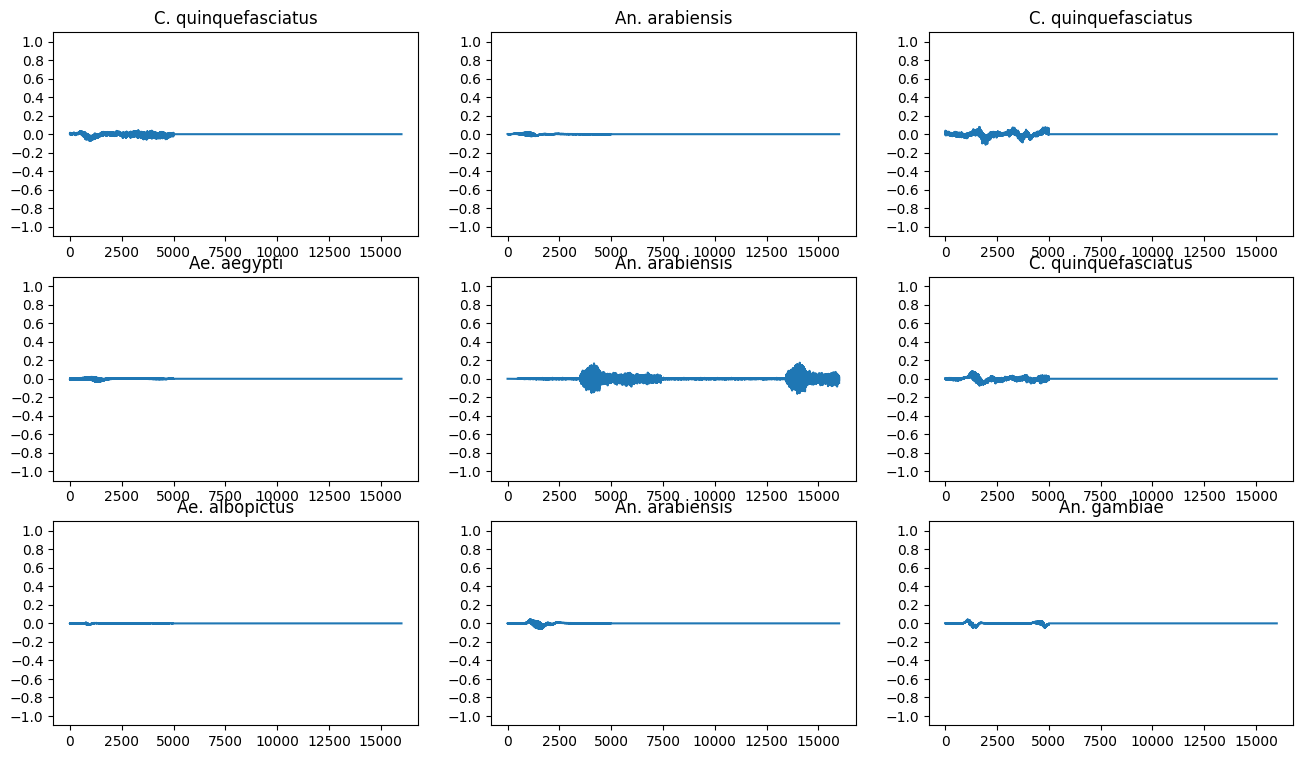

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)
  rows = 3
  cols = 3
  n = rows * cols
  fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

  for i in range(n):
    if i>=n:
      break
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[example_labels[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])

  plt.show()

A function to convert the time series wav signal to spectogram images

In [ ]:
# Convert waveforms to spectrograms
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram


Audio Sample form the dataset

In [ ]:
for i in range(6):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: C. quinquefasciatus
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: An. arabiensis
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: C. quinquefasciatus
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: Ae. aegypti
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: An. arabiensis
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: C. quinquefasciatus
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


A function to plot the spectogram

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


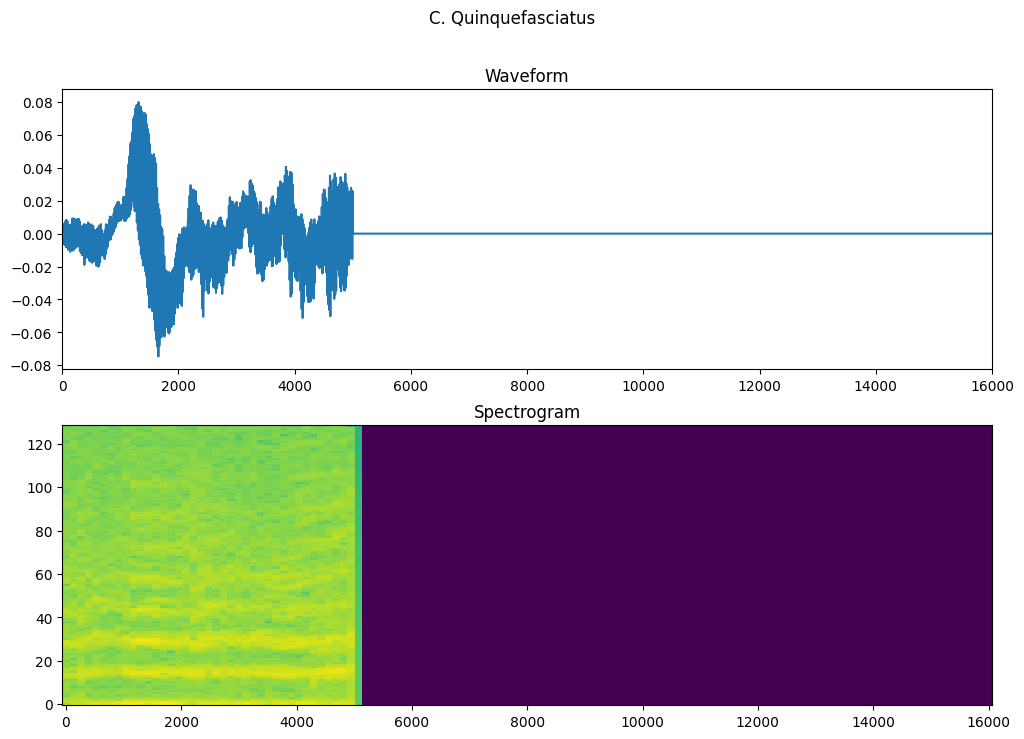

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Function to create spectogram for batch of audio files


In [ ]:
def make_spec_ds(ds):
  after = ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)
  return after




In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Ploting sample spectograms form different species

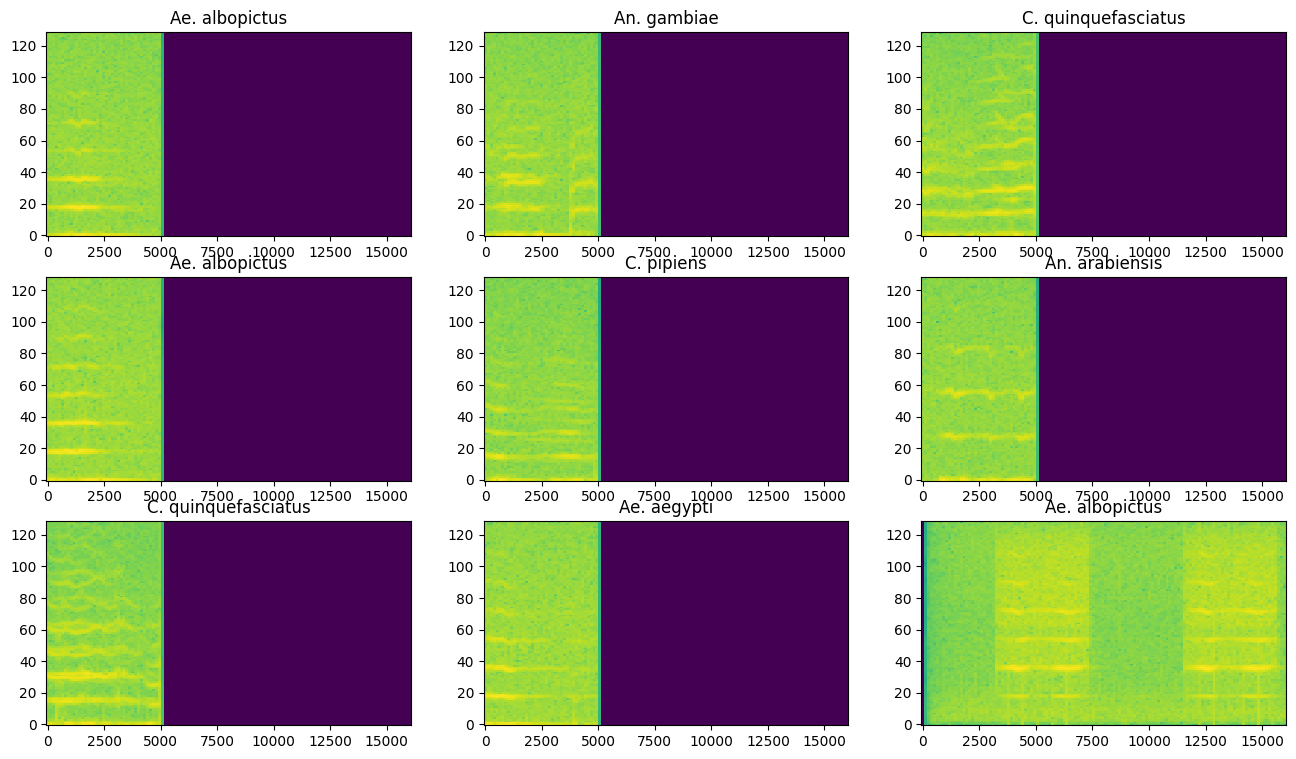

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

The convolutional nural network architecture

In [ ]:


input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    Input(shape=input_shape),
    # Downsample the input.
    Resizing(64, 64),
    # Normalize.
    norm_layer,
    Conv2D(64, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, 3, activation='relu'),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, 3, activation='relu'),
    Conv2D(256, 3, activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
])



model.summary()

# 128 > 64 > 32 rasinate architecture, inseption > optimal filter 3

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 64, 64, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

Compiling the model/architecture

In [ ]:
# learning_scheduler=tf.keras.callbacks.LearningRateScheduler(lambda epochs: 1e-8 * 10**(epochs/20))
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
    # callbacks=[learning_scheduler]
)

Training the built architecture with out dataset.

In [ ]:
EPOCHS = 200
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=4),
)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


83/83 [==============================] - 12s 71ms/step - loss: 1.7920 - accuracy: 0.1986 - val_loss: 1.7628 - val_accuracy: 0.2969
Epoch 2/200
83/83 [==============================] - 4s 45ms/step - loss: 1.4681 - accuracy: 0.3753 - val_loss: 1.2233 - val_accuracy: 0.5641
Epoch 3/200
83/83 [==============================] - 4s 45ms/step - loss: 1.1423 - accuracy: 0.5337 - val_loss: 1.0257 - val_accuracy: 0.6156
Epoch 4/200
83/83 [==============================] - 4s 45ms/step - loss: 0.9548 - accuracy: 0.6242 - val_loss: 0.8049 - val_accuracy: 0.6828
Epoch 5/200
83/83 [==============================] - 4s 46ms/step - loss: 0.8607 - accuracy: 0.6653 - val_loss: 0.7673 - val_accuracy: 0.6953
Epoch 6/200
83/83 [==============================] - 4s 45ms/step - loss: 0.8093 - accuracy: 0.6864 - val_loss: 0.8349 - val_accuracy: 0.6781
Epoch 7/200
83/83 [==============================] - 4s 45ms/step - loss: 0.7387 - accuracy: 0.7103 - val_loss: 0.7232 - val_accuracy: 0.7156
Epoch 8/200
83/83

In [ ]:
!mkdir -p saved_model

In [ ]:
model.save('saved_model/my_model.h5')

Text(0, 0.5, 'Accuracy [%]')

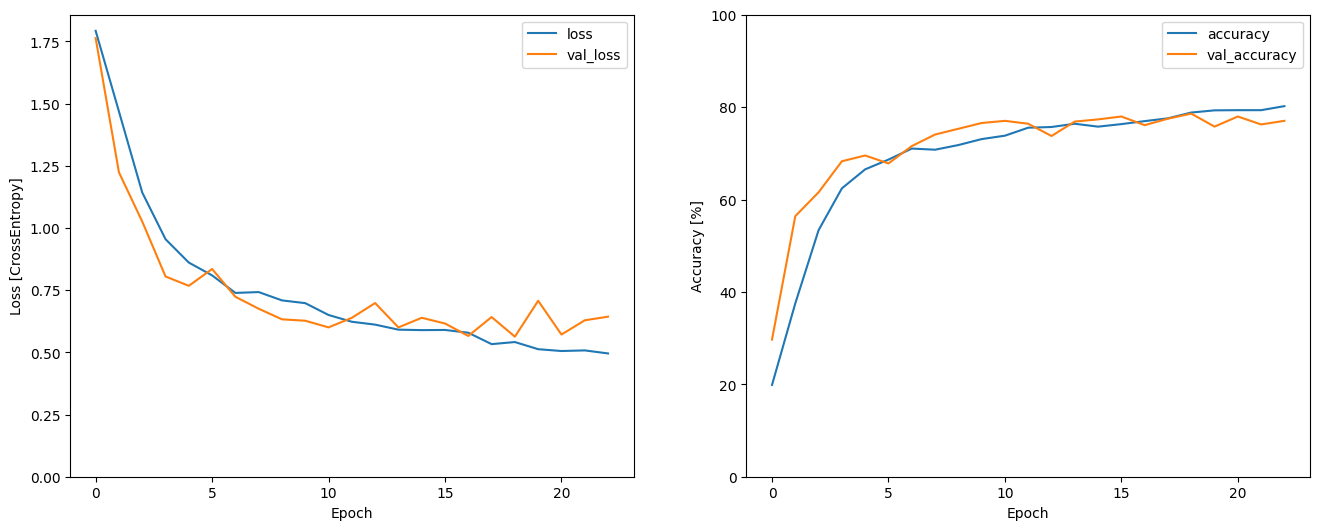

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

11/11 [==============================] - 0s 15ms/step - loss: 0.7476 - accuracy: 0.7622


{'loss': 0.7476025223731995, 'accuracy': 0.7621861100196838}

Predictions with adio that has a noise

In [ ]:
model=tf.keras.models.load_model("/content/drive/MyDrive/my_model.h5",compile=False)

In [ ]:
y_pred = model.predict(test_spectrogram_ds)

11/11 [==============================] - 10s 95ms/step


In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

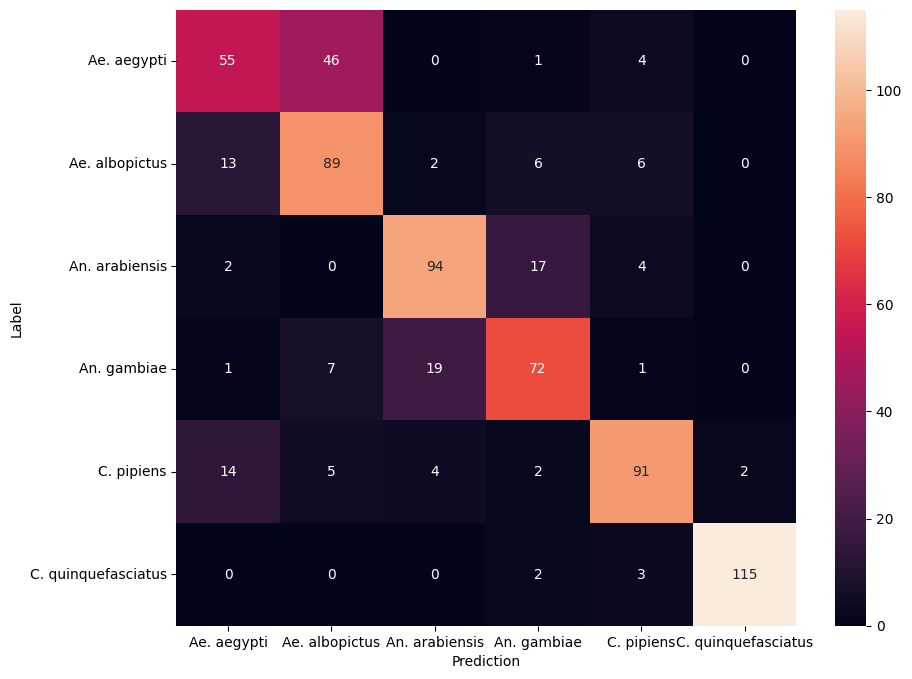

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

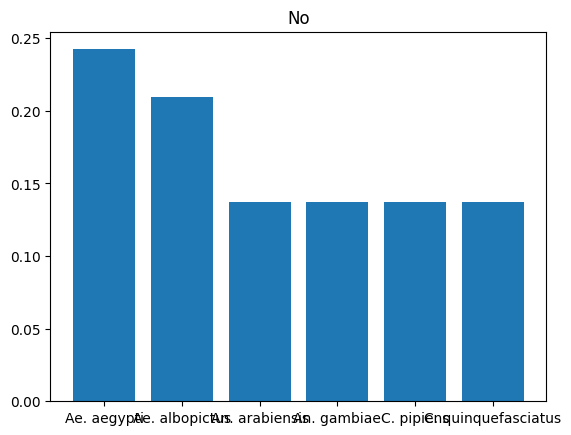

In [ ]:
x = '/content/WingBeatsDS/Ae. aegypti/2023-06-12 093316.359491 audio.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
# x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))